In [50]:
from pandas.core.indexes.interval import date_range
from pandas import DataFrame
import numpy as np
from collections import defaultdict, OrderedDict, Counter
import sys
import random
from typing import NamedTuple, Set

class Route(NamedTuple):
    origin: str
    destination: str
    cost: int
    num_edges: int
    edges: Set[int]


class Node(NamedTuple):
    cities: Set[str]
    cost: int
    double: bool


class Graph:
    distance_to_search = 10  # no two cities are more than 10 edges apart
    
    def __init__(self, graph=None, file=None):
        if graph:
            self.graph = graph
        if file:
            self.graph = self._parse_graph_from_file(file)

    def _parse_graph_from_file(self, file_name):
        self.edges = dict()
        graph = defaultdict(list)
        with open(file_name, 'r') as fob:
            for id, line in enumerate(fob):
                from_, to_, distance_, is_double_ = line.split(',')
                self.edges[id] = Node(set([from_, to_]), int(distance_), is_double_ == 'true')
                graph[from_].append([to_, int(distance_), id])
                graph[to_].append([from_, int(distance_), id])

        return graph
    
    def nodes(self):
        return sorted(self.graph)

    def potential_tickets(self, origin_city):
        # TODO: there is a bug in the cost calculation, e.g. the Antalya-Van ticket sets the cost too high.
        # Write a test case, check scores for other tickets
        found = []
        seen = set([origin_city])
        cities = [[origin_city, 0, tuple()]]
        
        for num_edges in range(self.distance_to_search):
            newcities = []
            for city, cost, ids in cities:
                connections = self.graph[city]
                for city_, cost_, id_ in connections:
                    #print(city, cost, city_, cost_, seen)
                    if city_ in seen:
                        continue
                    seen.add(city_)
                    total = cost + cost_
                    newids = ids + (id_,)
                    if num_edges >= 1 and origin_city < city_:
                        found.append(Route(origin_city, city_, total, num_edges + 1, set(newids)))
                    newcities.append([city_, total, newids])
            cities = newcities
        return found


def main(dta):
    graph = Graph(file=dta) if type(dta) == str else Graph(graph=dta)
    nodes = graph.nodes()
    print("city count: {}".format(len(nodes)))
    
    tickets = []
    for node in nodes:
        tickets += graph.potential_tickets(node)
    
    return graph, tickets


def test_main_deprecated():
    graph = {'Ankara': [['Eskisehir', 2, 0]], 
             'Eskisehir': [['Ankara', 2, 0], ['Istanbul', 2, 1]],
             'Istanbul': [['Eskisehir', 2, 1]]}
    expected_tickets = [Route('Ankara', 'Istanbul', 4, 2, set([0, 1]))]
    assert main(graph) == expected_tickets
    print("yay\n")

def get_tickets(num=10000):
    file = "cities.csv"
    graph, tickets = main(file)
    scores = []
    for _ in range(num):
        scores.append(ticket_score(random.sample(tickets, 40), graph))
    return graph, tickets, scores

    
def test_main2():
    file = "cities.csv"
    graph, tickets = main(file)

    edges_per_route = defaultdict(int)
    for t in tickets:
        edges_per_route[t[3]] += 1
    print("edges per route distribution:\n\t{}".format(dict(edges_per_route)))

    
    cost_per_route = defaultdict(int)
    for t in tickets:
        cost_per_route[t[2]] += 1
    
    print("cost per route distribution:\n\t{}".format(dict(cost_per_route)))

    print("tickets count: {}".format(len(tickets)))
    for t in tickets:
        if t.edges == 9:
            print(t) 

    print()
    for t in tickets:
        if t.origin == 'Van' or t.destination == 'Van':
            print(t)


    return DataFrame(scores)


def score_data_to_scalar(score_data, graph):
    pct_used_edges = (len(graph.edges) - score_data['unused_edges']) / len(graph.edges)
    pct_used_destinations = (len(graph.nodes()) - score_data['unused_terminals']) / len(graph.nodes())


def ticket_score(tickets, graph):
    # minimal overlap
    overlaps = {n: 0 for n in graph.edges.keys()}
    end_cities = defaultdict(int)
    for ticket in tickets:
        end_cities[ticket.origin] += 1
        end_cities[ticket.destination] += 1
        for edge in ticket.edges:
            overlaps[edge] += 1

    score_data = dict(
        tickets=tickets,
        unused_edges=sum(n == 0 for n in overlaps.values()),
        unused_terminals=len(graph.nodes()) - len(end_cities),
        most_common_edge=max(overlaps.values()),
        most_common_terminal=max(end_cities.values()),
        edge_std=np.std(list(overlaps.values())),
        terminal_std=np.std(list(end_cities.values())),
    )
    return score_data


def print_tickets(tickets, graph):
    print('- ticket score -')

    overlaps = {n: 0 for n in graph.edges.keys()}
    terminals = defaultdict(int)
    for ticket in tickets:
        print(ticket)
        terminals[ticket.origin] += 1
        terminals[ticket.destination] += 1
        for edge in ticket.edges:
            overlaps[edge] += 1
        
    for common in Counter(overlaps).most_common(10):
        print(f'Common Edge: - {common} - {graph.edges[common[0]]}')
    for common in Counter(terminals).most_common(10):
        print(f'Common City: - {common}')

    terms = set(terminals.keys())
    for city in graph.nodes():
        if city not in terms:
            print(f'unused terminal: {city}')


if __name__ == "__main__":
    pass
    #test_main()
    #test_main2()

    
    #tickets = main(file="cities.csv")
    #print(tickets)


In [54]:
graph, tickets, scores = get_tickets(90000)
df = DataFrame(scores)
df

city count: 45


,tickets,unused_edges,unused_terminals,most_common_edge,most_common_terminal,edge_std,terminal_std
0,"[(Afyon, Çorum, 6, 3, {24, 34, 37}), (Trabzon,...",20,7,10,7,2.215711,1.230949
1,"[(Aksaray, Antalya, 6, 2, {28, 39}), (Konya, O...",22,5,8,5,1.901315,1.118034
2,"[(Sakarya, Sivas, 8, 3, {33, 36, 14}), (Alanya...",20,7,9,5,2.186571,1.187423
3,"[(Bolu, Erzincan, 10, 3, {33, 36, 54}), (Erzin...",25,4,12,5,2.335561,1.080903
4,"[(Denizli, Kars, 24, 7, {36, 37, 17, 18, 54, 2...",21,7,12,7,2.616176,1.372464
...,...,...,...,...,...,...,...
89995,"[(Artvin, Tekirdağ, 19, 8, {1, 4, 14, 47, 49, ...",25,6,11,5,2.119994,1.131115
89996,"[(Bolu, Kayseri, 6, 2, {33, 35}), (Samsun, Van...",29,6,11,5,2.421228,0.904369
89997,"[(Isparta, Muğla, 4, 2, {19, 20}), (Antalya, M...",17,4,11,4,2.344008,0.986524
89998,"[(Gaziantep, Tekirdağ, 15, 6, {33, 1, 35, 4, 1...",23,4,14,4,2.805101,0.909334


In [56]:
df.describe()
numeric = df[['unused_edges', 'unused_terminals', 'most_common_edge', 'most_common_terminal', 'edge_std', 'terminal_std']]
numeric
n_df=(numeric-numeric.mean())/numeric.std()
n_df['tickets'] = df['tickets']
n_df['simple_sum'] = n_df.sum(axis=1, numeric_only=True)
n_df['weighted_sum'] = (
    n_df['unused_edges'] * 4 + 
    n_df['unused_terminals'] + 
    n_df['most_common_edge'] * 2 + 
    n_df['most_common_terminal'] + 
    n_df['edge_std'] * 2 + 
    n_df['terminal_std']
)
smallest = list(n_df.nlargest(10, 'weighted_sum').index)
print_tickets(df.iloc[smallest[0]].tickets, Graph(file='cities.csv'))
print(df.iloc[smallest[0]])
print_tickets(df.iloc[smallest[1]].tickets, Graph(file='cities.csv'))
print(df.iloc[smallest[1]])
print_tickets(df.iloc[smallest[2]].tickets, Graph(file='cities.csv'))
print(df.iloc[smallest[2]])
print_tickets(df.iloc[smallest[3]].tickets, Graph(file='cities.csv'))
print(df.iloc[smallest[3]])
print_tickets(df.iloc[smallest[4]].tickets, Graph(file='cities.csv'))
print(df.iloc[smallest[4]])
print_tickets(df.iloc[smallest[5]].tickets, Graph(file='cities.csv'))
print(df.iloc[smallest[5]])
df.iloc[smallest]

- ticket score -
Route(origin='Kars', destination='Çanakkale', cost=25, num_edges=7, edges={36, 37, 7, 17, 54, 56, 24})
Route(origin='Erzincan', destination='Çanakkale', cost=19, num_edges=6, edges={36, 37, 7, 17, 54, 24})
Route(origin='Adana', destination='İzmir', cost=11, num_edges=4, edges={40, 25, 43, 17})
Route(origin='Sakarya', destination='Tatvan', cost=17, num_edges=6, edges={33, 36, 69, 73, 14, 55})
Route(origin='Antalya', destination='Erzincan', cost=15, num_edges=5, edges={36, 37, 38, 54, 28})
Route(origin='Ankara', destination='Çanakkale', cost=11, num_edges=4, edges={24, 17, 37, 7})
Route(origin='Balıkesir', destination='İskenderun', cost=15, num_edges=6, edges={67, 40, 10, 43, 17, 25})
Route(origin='Edirne', destination='Malatya', cost=17, num_edges=7, edges={0, 1, 33, 4, 36, 14, 55})
Route(origin='Niğde', destination='Tekirdağ', cost=17, num_edges=6, edges={2, 7, 40, 42, 17, 25})
Route(origin='Afyon', destination='Sivas', cost=8, num_edges=3, edges={24, 36, 37})
Route(or

,tickets,unused_edges,unused_terminals,most_common_edge,most_common_terminal,edge_std,terminal_std
76757,"[(Kars, Çanakkale, 25, 7, {36, 37, 7, 17, 54, ...",35,9,19,6,3.995623,1.293383
6903,"[(Elaziğ, Konya, 14, 5, {36, 37, 38, 54, 57}),...",35,10,21,4,4.146365,1.110249
17696,"[(Denizli, Ordu, 17, 6, {36, 37, 17, 18, 50, 2...",35,11,16,7,3.453621,1.432447
40231,"[(Edirne, Tatvan, 23, 9, {0, 1, 33, 4, 36, 69,...",30,12,20,7,3.807374,1.393280
59877,"[(Ankara, Elaziğ, 10, 3, {57, 36, 54}), (Sakar...",33,12,20,5,3.758241,1.231661
5688,"[(Diyarbakır, Erzincan, 9, 4, {74, 69, 54, 55}...",33,9,18,6,3.703377,1.529544
42207,"[(Balıkesir, Trabzon, 15, 7, {9, 11, 14, 47, 4...",30,8,22,6,4.048128,1.305156
84360,"[(Ankara, Elaziğ, 10, 3, {57, 36, 54}), (Elazi...",32,12,18,7,3.279100,1.652002
29628,"[(Erzincan, Isparta, 12, 5, {36, 37, 54, 24, 2...",32,8,22,5,4.005543,1.078375
12827,"[(Ordu, Çanakkale, 18, 6, {36, 37, 7, 17, 50, ...",35,7,21,4,3.700317,1.142239


In [25]:
df.describe()

,unused_edges,unused_terminals,most_common_edge,most_common_terminal,edge_std,terminal_std
count,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,22.024200,6.592900,12.473000,5.176400,2.647072,1.121530
std,3.184718,1.910899,2.279691,0.874848,0.316490,0.138236
min,12.000000,0.000000,6.000000,3.000000,1.732006,0.638456
25%,20.000000,5.000000,11.000000,5.000000,2.426900,1.024695
50%,22.000000,7.000000,12.000000,5.000000,2.628688,1.108330
75%,24.000000,8.000000,14.000000,6.000000,2.849753,1.208811
max,35.000000,14.000000,22.000000,10.000000,4.018706,1.758620


nodes 45 50
edges 80 89
track 200 265


<Axes: xlabel='cost'>

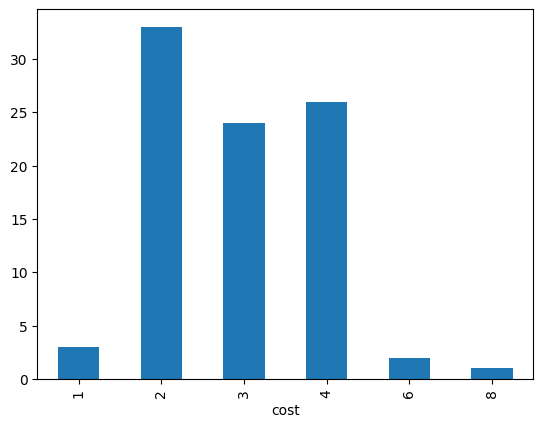

In [76]:
tu_graph = Graph(file='cities.csv')
eur_graph = Graph(file='eur_cities.csv')
print('nodes', len(tu_graph.nodes()), len(eur_graph.nodes()))
print('edges', len(tu_graph.edges), len(eur_graph.edges))
print('track', sum(e.cost for e in tu_graph.edges.values()), sum(e.cost for e in eur_graph.edges.values()))
eu_df = DataFrame(eur_graph.edges.values())
eu_df['cost'].value_counts().sort_index().plot.bar()

0.9
0.9
0.75
Axes(0.125,0.11;0.775x0.77)


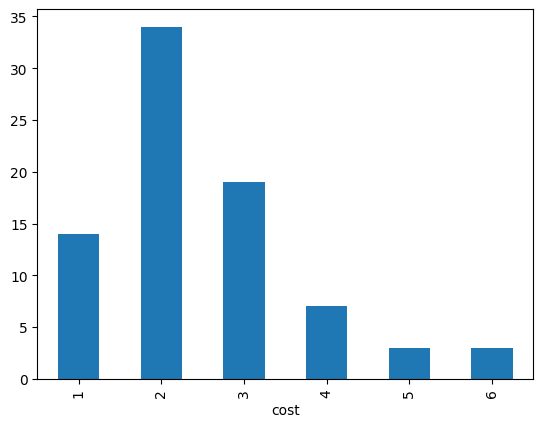

In [77]:
print(round(45/50, 2))
print(round(80/89, 2))
print(round(200/265, 2))

tr_df = DataFrame(tu_graph.edges.values())
print(tr_df['cost'].value_counts().sort_index().plot.bar())